In [1]:
import pandas as pd
import torch

# 수정된 로컬 모듈들을 임포트합니다.
from data_process import get_market_data
from env import MultiAssetPortfolioEnv
from agent import Agent
from evaluation import evaluate_agent
from utils import calculate_initial_weights # utils.py에 추가할 초기 가중치 계산 함수

torch.multiprocessing.set_start_method('fork', force=True)

In [2]:
# =================================================================================
# 1. 설정 (Configuration)
# =================================================================================

# --- 데이터 관련 파라미터 ---
# 사용자께서 제안하신 티커 목록을 사용합니다.
# 주식: Apple, Microsoft, Amazon, Google
# 미국 시장 지수 ETF: SPY
# 단기 채권 ETF: BIL (무위험 자산 대용)
# 장기 채권 ETF: TLT
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOG", "SPY", "BIL", "TLT"]
START_DATE = "2015-01-01"
TRAIN_END_DATE = "2022-12-31" # 훈련 기간 종료일
TEST_END_DATE = "2024-12-31"  # 테스트 기간 종료일

# --- 환경 관련 파라미터 ---
INITIAL_PORTFOLIO_VALUE = 1000000  # 초기 포트폴리오 가치 (백만 달러)
TRANSACTION_COST_PCT = 0.001       # 거래 비용 (0.1%)
RISK_AVERSION_COEFF = 0         # 위험 회피 계수 (보상 함수에 사용)

# --- 에이전트 및 훈련 관련 파라미터 ---
RANDOM_SEED = 42
N_EPISODES = 5  # 훈련 에피소드 수

print("="*80)
print(" " * 15 + "DDPG Multi-Asset Portfolio Optimization")
print("="*80)

               DDPG Multi-Asset Portfolio Optimization


In [3]:
# =================================================================================
# 2. 데이터 준비 (Data Preparation)
# =================================================================================
print(f"\n[1/5] 📈 데이터 로딩 및 전처리 중... (기간: {START_DATE} ~ {TEST_END_DATE})")
full_data_df = get_market_data(
    tickers=TICKERS,
    start_date=START_DATE,
    end_date=TEST_END_DATE
)

# 훈련 데이터와 테스트 데이터 분리 (Lookahead Bias 방지)
train_df = full_data_df.loc[:TRAIN_END_DATE]
test_df = full_data_df.loc[TRAIN_END_DATE:]
print(f"✅ 데이터 준비 완료: 훈련 데이터 {len(train_df)}일, 테스트 데이터 {len(test_df)}일")


[1/5] 📈 데이터 로딩 및 전처리 중... (기간: 2015-01-01 ~ 2024-12-31)


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed

✅ 데이터 준비 완료: 훈련 데이터 1955일, 테스트 데이터 501일



/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='bfill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [4]:
# =================================================================================
# 3. 환경 및 에이전트 생성 (Instantiation)
# =================================================================================
print("\n[2/5] 🛠️  훈련 환경 및 에이전트 생성 중...")

# 초기 가중치 계산 (utils.py 함수 사용, 여기서는 동일 비중으로 가정)
# 사용자께서는 이 부분에 '유사 포트폴리오 기반' 로직을 적용하실 수 있습니다.
initial_weights = calculate_initial_weights(assets=TICKERS, method='equal')

# 훈련 환경 생성
train_env = MultiAssetPortfolioEnv(
    df=train_df,
    assets=TICKERS,
    initial_weights=initial_weights,
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT,
    risk_aversion_coeff=RISK_AVERSION_COEFF
)

# 환경으로부터 state 및 action 크기 확보
state_size = train_env.observation_space.shape[0]
action_size = train_env.action_space.shape[0]

# 에이전트 생성
agent = Agent(state_size=state_size, action_size=action_size, random_seed=RANDOM_SEED)
print(f"✅ 에이전트 생성 완료: State Size={state_size}, Action Size={action_size}")


[2/5] 🛠️  훈련 환경 및 에이전트 생성 중...
✅ 에이전트 생성 완료: State Size=1289, Action Size=8


In [5]:
# =================================================================================
# 4. 모델 훈련 (Training)
# =================================================================================
print(f"\n[3/5] 🧠 모델 훈련 시작... (총 {N_EPISODES} 에피소드)")

# agent.py의 train 메소드가 tqdm을 내장하고 있으므로 여기서 호출만 하면 됩니다.
agent.train(env=train_env, n_episodes=N_EPISODES)
print("\n✅ 모델 훈련 완료.")


[3/5] 🧠 모델 훈련 시작... (총 5 에피소드)


Training Progress: 100%|██████████| 5/5 [04:00<00:00, 48.01s/it]


✅ 모델 훈련 완료.



[4/5] 📊 모델 평가 시작 (Out-of-Sample Backtest)...
--- Running Backtest for DDPG Agent ---



--- Running Backtest for Equal Weight Benchmark ---

               PERFORMANCE SUMMARY
              CAGR Annualized Volatility Sharpe Ratio Max Drawdown (MDD)
DDPG Agent   9.05%                 4.91%         1.84             -3.61%
Benchmark   24.64%                13.15%         1.87             -9.36%



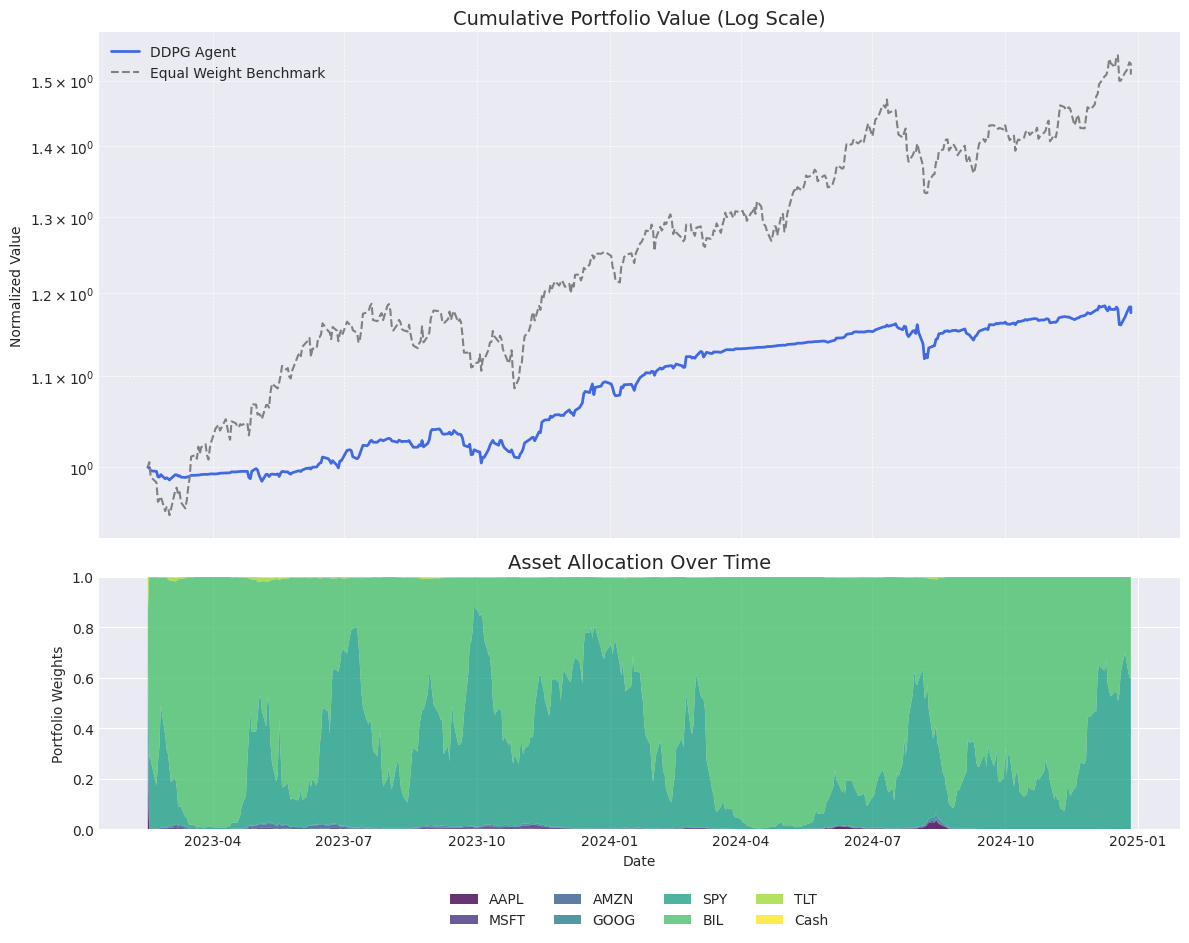


[5/5] ✅ 평가 및 시각화 완료.


In [6]:
# =================================================================================
# 5. 모델 평가 (Evaluation)
# =================================================================================
print("\n[4/5] 📊 모델 평가 시작 (Out-of-Sample Backtest)...")

# 평가 환경 생성 (훈련에 사용되지 않은 test_df 사용)
test_env = MultiAssetPortfolioEnv(
    df=test_df,
    assets=TICKERS,
    initial_weights=initial_weights, # 훈련 시작 시점의 가중치로 평가 시작
    initial_portfolio_value=INITIAL_PORTFOLIO_VALUE,
    transaction_cost_pct=TRANSACTION_COST_PCT,
    risk_aversion_coeff=RISK_AVERSION_COEFF
)

# evaluation.py의 평가 함수 호출
evaluate_agent(env=test_env, agent=agent)
print("\n[5/5] ✅ 평가 및 시각화 완료.")
print("="*80)